In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from seaborn import load_dataset

In [2]:
# if you've lost the associated utils file for this lecture, use the code in Appendix A, below
from utils import plot_y_vs_yhat, plot_predictions, evaluate, phi_curved, phi_periodic, phi_curved_and_periodic

# 6. Imputing Missing Values with Scikit-Learn


In this notebook, we discuss how to deal with missing values. In the process, we will work through feature engineering to construct a model that predicts vehicle efficiency.


## 6.1 Load `mpg` Dataset

For this notebook, we will use the seaborn `mpg` data set which describes the fuel mileage (measured in miles per gallon or mpg) of various cars along with characteristics of those cars.  Our goal will be to build a model that can predict the fuel mileage of a car based on the characteristics of that car.

In [3]:
data = load_dataset("mpg")
data

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino
...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790,15.6,82,usa,ford mustang gl
394,44.0,4,97.0,52.0,2130,24.6,82,europe,vw pickup
395,32.0,4,135.0,84.0,2295,11.6,82,usa,dodge rampage
396,28.0,4,120.0,79.0,2625,18.6,82,usa,ford ranger


Notice a large number of columns are not quantitative continuous. Ignore these for now. We will deal with in next lesson.

In [4]:
Y = data[["mpg"]]

## 6.2 Keeping Track of Progress

Because we are going to be building multiple models with different feature functions it is important to have a standard way to track each of the models.  

The following function takes a model prediction function, the name of a model, and the dictionary of models that we have already constructed.  It then evaluates the new model on the data and plots how the new model performs relative to the previous models as well as the $Y$ vs $\hat{Y}$ scatter plot.  

In addition, it updates the dictionary of models to include the new model for future plotting.

In [9]:
results = {}

In [10]:
def evaluate_and_plot_mpg(name, df, y, yhat):
    metrics = evaluate(df, y, yhat)
    plot_y_vs_yhat(df, y, yhat)
    
    results[name] = metrics
    return pd.DataFrame(results).sort_values(by='MSE', axis=1).T

## 6.3 Imputing Missing Quantitative Continuous Features

This data set has several quantitative continuous features that we can use to build our first model.  However, even for quantitative continuous features, we may want to do some additional feature engineering.  Things to consider are:

1. transforming features with non-linear functions (log, exp, sine, polynomials)
2. constructing products or ratios of features
3. dealing with missing values

### Missing Values

We can use the Pandas `DataFrame.isna` function to find rows with missing values:

In [5]:
data[data.isna().any(axis=1)]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
32,25.0,4,98.0,NaN,2046,19.0,71,usa,ford pinto
126,21.0,6,200.0,NaN,2875,17.0,74,usa,ford maverick
330,40.9,4,85.0,NaN,1835,17.3,80,europe,renault lecar deluxe
336,23.6,4,140.0,NaN,2905,14.3,80,usa,ford mustang cobra
354,34.5,4,100.0,NaN,2320,15.8,81,europe,renault 18i
374,23.0,4,151.0,NaN,3035,20.5,82,usa,amc concord dl


There are many ways to deal with missing values.  A common strategy is to substitute the mean.  Because missing values can actually be useful signal, it is often a good idea to include a feature indicating that the value was missing. 

In [6]:
def impute_mpg(df):
    Phi = df[["cylinders", "displacement", 
              "horsepower", "weight", 
              "acceleration", 
              "model_year"]].copy()
    Phi["horsepower_missing"] = Phi["horsepower"].isna()
    Phi = Phi.fillna(Phi.mean())
    return Phi

### Baseline Biased OLS Model

Using our feature function, we can fit our first model to the transformed data:

In [7]:
def train_model_with_phi(df, phi, X, Y):
    model = LinearRegression()
    Phi = phi(X)
    model.fit(Phi, Y)
    yhat = model.predict(Phi)
    return model, yhat

In [8]:
basic, yhat = train_model_with_phi(data, impute_mpg, data, Y)
data['Yhat'] = yhat

Mean Squared Error: 11.655535856999618
Mean Absolute Error: 2.6300102173760966
Root Mean Squared Error: 3.414020482803174


,MAE,MSE,RMSE
basic,2.63001,11.655536,3.41402


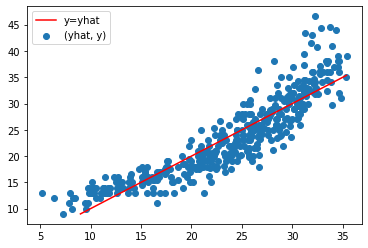

In [11]:
evaluate_and_plot_mpg('basic', data, y="mpg", yhat="Yhat")

## 6.4 Stable Feature Functions

Unfortunately, the feature function we just implemented applies a different transformation depending on what input we provide. Specifically, if the `horsepower` is missing when we go to make a prediction we will substitute it with a different mean then was used when we fit our model.  Furthermore, if we only want predictions on a few records and the `horsepower` is missing from those records then the feature function will be unable to substitute a meaningful value.

For example, if we were to get new records that look like the following:

In [12]:
new_data = data[data['horsepower'].isna()].head(3)
new_data

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name,Yhat
32,25.0,4,98.0,NaN,2046,19.0,71,usa,ford pinto,25.916113
126,21.0,6,200.0,NaN,2875,17.0,74,usa,ford maverick,22.400660
330,40.9,4,85.0,NaN,1835,17.3,80,europe,renault lecar deluxe,33.964920


The feature function is be unable to substitute the mean since none of the records have a `horsepower` value.

In [13]:
try:
    basic.predict(impute_mpg(new_data))
except Exception as e:
    print(e)

Input contains NaN, infinity or a value too large for dtype('float64').


We can fix this by computing the mean on the original data and using that mean on any new data.

In [14]:
# Making a global variable
def impute_mpg(df, data_mean = data.mean()):
    feature_cols = ["cylinders", "displacement", "horsepower", "weight", "acceleration", "model_year"]
    Phi = df[feature_cols].copy()
    Phi["horsepower_missing"] = Phi["horsepower"].isna().astype(float)
    Phi = Phi.fillna(data_mean)
    return Phi

/tmp/ipykernel_920/1297707433.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  def impute_mpg(df, data_mean = data.mean()):


In [15]:
basic.predict(impute_mpg(new_data))

array([[25.91611313],
       [22.40066016],
       [33.96492047]])

## 6.5 Scikit-learn Model Imputer

Because these kinds of transformations are fairly common. Scikit-learn has built-in transformations for data imputation.  These transformations have a common pattern of `fit` and `transform`.  You first `fit` the transformation to your data and then you can `transform` your data and any future data using the same transformation.

In [16]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="mean")

In [17]:
imputer.fit(data[['weight', 'horsepower']])

SimpleImputer()

In [18]:
imputer.transform(data[['weight', 'horsepower']])[32]

array([2046.        ,  104.46938776])

In [19]:
imputer.fit(data[['horsepower']])
def impute_mpg_sklearn(df, imputer=imputer):
    feature_cols = ["cylinders", "displacement", "horsepower", "weight", "acceleration", "model_year"]
    Phi = df[feature_cols].copy()
    Phi["horsepower_missing"] = Phi["horsepower"].isna().astype(float)
    Phi["horsepower"] = imputer.transform(Phi[["horsepower"]]).flatten()
    return Phi

Mean Squared Error: 11.655535856999618
Mean Absolute Error: 2.6300102173760966
Root Mean Squared Error: 3.414020482803174


,MSE,MAE,RMSE
basic,11.655536,2.63001,3.41402
basic_sklearn,11.655536,2.63001,3.41402


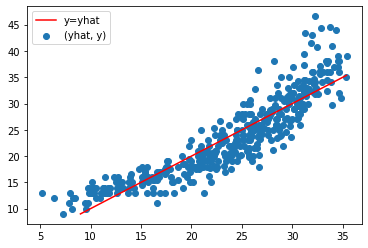

In [20]:
basicsk, data['Yhat'] = train_model_with_phi(data, impute_mpg_sklearn, data, Y)
evaluate_and_plot_mpg("basic_sklearn", data, y="mpg", yhat="Yhat")

# 7. Applying Domain Knowledge

Let's try improving the model by applying feature functions from before: polynomial and sinusoidal features.

The displacement of an engine is defined as the product of the volume of each cylinder and number of cylinders.  However, not all cylinders fire at the same time (at least in a functioning engine) so the fuel economy might be more closely related to the volume of any one cylinder.  

![Cylinders from https://gifimage.net/piston-gif-3/](https://gifimage.net/wp-content/uploads/2018/04/piston-gif-3.gif)

## 7.1 Displacement Features

We can use this "domain knowledge" to compute a new feature encoding the volume per cylinder by taking the ratio of displacement and cylinders. 

In [21]:
def phi_with_displacement(df):
    Phi = impute_mpg_sklearn(df)
    Phi['displacement/cylinder'] = Phi['displacement'] / Phi['cylinders']
    return Phi

Again fitting and evaluating our model we see a reduction in prediction error (RMSE).

Mean Squared Error: 9.124885140995026
Mean Absolute Error: 2.2237381270624215
Root Mean Squared Error: 3.0207424817410415


,MSE,MAE,RMSE
disp,9.124885,2.223738,3.020742
basic,11.655536,2.630010,3.414020
basic_sklearn,11.655536,2.630010,3.414020


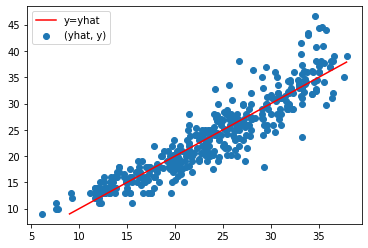

In [22]:
disp, data['Yhat_disp'] = train_model_with_phi(data, phi_with_displacement, data, Y)
evaluate_and_plot_mpg("disp", data, y="mpg", yhat="Yhat_disp")

## 7.2 Polynomial Features

Let's apply the feature functions we explored in the previous lesson. Do they work here?

In [23]:
def phi_crazy(df):
    Phi = impute_mpg_sklearn(df)
    Phi = phi_curved(Phi)
    return Phi

Mean Squared Error: 6.580192525428359
Mean Absolute Error: 1.8916719012627623
Root Mean Squared Error: 2.5651885945147113


,MSE,MAE,RMSE
crazy,6.580193,1.891672,2.565189
disp,9.124885,2.223738,3.020742
basic,11.655536,2.630010,3.414020
basic_sklearn,11.655536,2.630010,3.414020


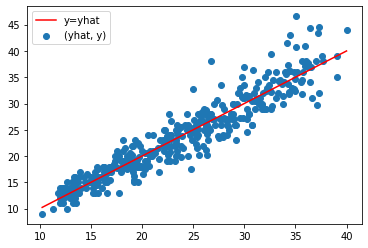

In [24]:
disp, data['Yhat_crazy'] = train_model_with_phi(data, phi_crazy, data, Y)
evaluate_and_plot_mpg("crazy", data, y="mpg", yhat="Yhat_crazy")

## 7.3 Sinusoidal Features

Those seemed to work well. Let's try more.

In [25]:
def phi_crazier(df):
    Phi = impute_mpg_sklearn(df)
    Phi = phi_curved_and_periodic(Phi)
    return Phi

Mean Squared Error: 6.10796346351352
Mean Absolute Error: 1.8161928427404483
Root Mean Squared Error: 2.471429437292014


,MSE,MAE,RMSE
crazier,6.107963,1.816193,2.471429
crazy,6.580193,1.891672,2.565189
disp,9.124885,2.223738,3.020742
basic,11.655536,2.630010,3.414020
basic_sklearn,11.655536,2.630010,3.414020


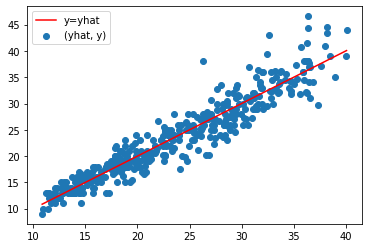

In [26]:
disp, data['Yhat_crazier'] = train_model_with_phi(data, phi_crazier, data, Y)
evaluate_and_plot_mpg("crazier", data, y="mpg", yhat="Yhat_crazier")

This random hodge podge of features is what we call "feature soup". It's senseless feature mashing to get a better result. We'll see why specifically this is bad, in future lectures. For now, it looks like feature soup is getting diminishing returns and has plateau'ed in performance. Hitting a wall here, we'll now turn to an alternative: Below, we'll leverage insights about the problem, our domain knowledge, to *further* significantly improve our model performance.

# 8. Encoding Non-Numeric and Categorical Data

## 8.1 Encoding Categorical Data 

The `origin` column in this data set is categorical (nominal) data taking on a fixed set of possible values.

In [27]:
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name,Yhat,Yhat_disp,Yhat_crazy,Yhat_crazier
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu,15.109165,14.207502,16.786522,15.754505
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320,14.145522,13.553382,15.062133,15.199882
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite,15.627641,14.162964,16.193132,16.178916
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst,15.647515,13.682197,15.569031,15.321225
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino,15.347630,13.918877,16.723288,16.500641


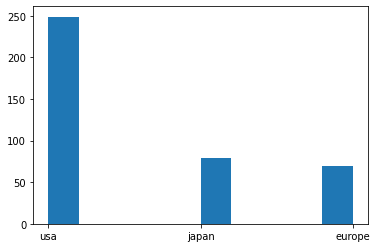

In [28]:
_ = plt.hist(data['origin'])

To use this kind of data in a model, we need to transform into a vector encoding that treats each distinct value as a separate dimension.  This is called One-hot Encoding or Dummy Encoding. 

### 8.1.1 One-Hot Encoding (Dummy Encoding)


One-Hot encoding, sometimes also called **dummy encoding** is a simple mechanism to encode categorical data as real numbers such that the magnitude of each dimension is meaningful.  Suppose a feature can take on $k$ distinct values (e.g., $k=50$ for 50 states in the United Stated).  A new feature (dimension) is created for each distinct value.  For each record, all the new features are set to zero except the one corresponding to the value in the original feature. 

<img src="images/one_hot_state.png" width="600px">

The term one-hot encoding comes from a digital circuit encoding of a categorical state as particular "hot" wire:

<img src="images/one_hot_encoding.png" width="400px">

### 8.1.2  Dummy Encoding in Pandas

We can construct a one-hot (dummy) encoding of the origin column using the `Pandas.get_dummies` function:

In [29]:
pd.get_dummies(data[['origin']])

,origin_europe,origin_japan,origin_usa
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
393,0,0,1
394,1,0,0
395,0,0,1
396,0,0,1


Using the `Pandas.get_dummies`, we can build a new feature function which extends our previous features with the additional dummy encoding columns.

In [57]:
def phi_with_origin(df):
    Phi = phi_with_displacement(df)
    Phi = Phi.join(pd.get_dummies(df[['origin']]))
    return Phi

We fit a new model with the origin feature encoding:

Mean Squared Error: 9.037171327747574
Mean Absolute Error: 2.224874824656813
Root Mean Squared Error: 3.006188837672639


,MSE,MAE,RMSE
name,1.840570,0.766515,1.356676
crazier,6.107963,1.816193,2.471429
crazy,6.580193,1.891672,2.565189
oh,9.037171,2.224875,3.006189
disp,9.124885,2.223738,3.020742
basic,11.655536,2.630010,3.414020
basic_sklearn,11.655536,2.630010,3.414020


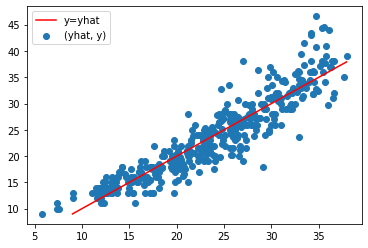

In [58]:
oh, data['Yhat_oh'] = train_model_with_phi(data, phi_with_origin, data, Y)
evaluate_and_plot_mpg("oh", data, y="mpg", yhat="Yhat_oh")

Unfortunately, the above feature function is not stable.  For example, if we are given a single vehicle to make a prediction the model will fail:

In [59]:
try:
    oh.predict(phi_with_origin(data.head(1)))
except Exception as e:
    print(e)

matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 11 is different from 9)


To see why this fails look at the feature transformation for a single row:

In [60]:
phi_with_origin(data.head(1))

,cylinders,displacement,horsepower,weight,acceleration,model_year,horsepower_missing,displacement/cylinder,origin_usa
0,8,307.0,130.0,3504,12.0,70,0.0,38.375,1


The dummy columns are not created for the other categories.  

There are a couple solutions.  We could maintain a list of dummy columns and always add these columns.  Alternatively, we could use a library function designed to solve this problem.  The second option is much easier.  

### 8.1.3 Scikit-learn One-hot Encoder

The scikit-learn library has a wide range feature transformations and a framework for composing them in reusable (stable) pipelines.  Let's first look at a basic [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) transformation.

In [61]:
from sklearn.preprocessing import OneHotEncoder
oh_enc = OneHotEncoder()

We then fit that instance to some data.  This is where we would determine the specific values that a categorical feature can take:

In [62]:
oh_enc.fit(data[['origin']])

OneHotEncoder()

Once we fit the transformation, we can then use it transform new data:

In [63]:
oh_enc.transform(data[['origin']].head())

<5x3 sparse matrix of type '<class 'numpy.float64'>'
	with 5 stored elements in Compressed Sparse Row format>

In [64]:
oh_enc.transform(data[['origin']].head()).todense()

matrix([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]])

We can also inspect the categories of the one-hot encoder:

In [65]:
oh_enc.get_feature_names()

array(['x0_europe', 'x0_japan', 'x0_usa'], dtype=object)

We can update our feature function to use the one-hot encoder instead.

In [66]:
def phi_with_origin(df):
    Phi = phi_with_displacement(df)
    dummies = pd.DataFrame(oh_enc.transform(df[['origin']]).todense(), 
                           columns=oh_enc.get_feature_names(),
                           index = df.index)
    return Phi.join(dummies)

In [67]:
phi_with_origin(data.head())

,cylinders,displacement,horsepower,weight,acceleration,model_year,horsepower_missing,displacement/cylinder,x0_europe,x0_japan,x0_usa
0,8,307.0,130.0,3504,12.0,70,0.0,38.375,0.0,0.0,1.0
1,8,350.0,165.0,3693,11.5,70,0.0,43.750,0.0,0.0,1.0
2,8,318.0,150.0,3436,11.0,70,0.0,39.750,0.0,0.0,1.0
3,8,304.0,150.0,3433,12.0,70,0.0,38.000,0.0,0.0,1.0
4,8,302.0,140.0,3449,10.5,70,0.0,37.750,0.0,0.0,1.0


Mean Squared Error: 9.037171327747574
Mean Absolute Error: 2.224874824656813
Root Mean Squared Error: 3.006188837672639


,MSE,MAE,RMSE
name,1.840570,0.766515,1.356676
crazier,6.107963,1.816193,2.471429
crazy,6.580193,1.891672,2.565189
oh,9.037171,2.224875,3.006189
disp,9.124885,2.223738,3.020742
basic,11.655536,2.630010,3.414020
basic_sklearn,11.655536,2.630010,3.414020


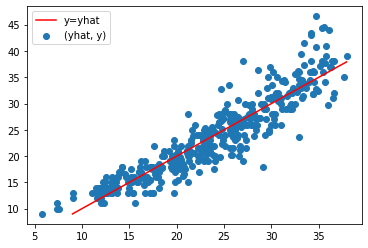

In [68]:
# model = LinearRegression()
# model.fit(phi_with_origin(data), data[["mpg"]])
# evaluate_model("cont.+(d/c)+o", model, phi_with_origin, models)
oh, data['Yhat_oh'] = train_model_with_phi(data, phi_with_origin, data, Y)
evaluate_and_plot_mpg("oh", data, y="mpg", yhat="Yhat_oh")

## 8.2 Encoding Text using Bag-of-Words

The only remaining feature to encode is the vehicle name.  Is there potentially signal in the vehicle name?


In [69]:
data[['name']].head(10)

,name
0,chevrolet chevelle malibu
1,buick skylark 320
2,plymouth satellite
3,amc rebel sst
4,ford torino
5,ford galaxie 500
6,chevrolet impala
7,plymouth fury iii
8,pontiac catalina
9,amc ambassador dpl


Encoding text can be challenging.  The capturing the semantics and grammar of language in mathematical (vector) representations is an active area of research.  State-of-the-art techniques often rely on neural networks trained on large collections of text. In this class, we will focus on basic text encoding techniques that are still widely used.  If you are interested in learning more, checkout [BERT Explained: A Complete Guide with Theory and Tutorial](https://towardsml.com/2019/09/17/bert-explained-a-complete-guide-with-theory-and-tutorial).



Here we present two widely used representations of text:

* **Bag-of-Words Encoding**: encodes text by the frequency of each word
* **N-Gram Encoding**: encodes text by the frequency of sequences of words of length $N$

Both of these encoding strategies are related to the one-hot encoding with dummy features created for every word or sequence of words and with multiple dummy features having counts greater than zero.


### 8.2.1 The Bag-of-Words Encoding


The bag-of-words encoding is widely used and a standard representation for text in many of the popular text clustering algorithms.  The following is a simple illustration of the bag-of-words encoding:

<img src="images/bag_of_words.png" width="600px">

**Notice**
1. **Stop words are often removed.** Stop-words are words like `is` and `about` that in isolation contain very little information about the meaning of the sentence.  Here is a good list of [stop-words in many languages](https://code.google.com/archive/p/stop-words/). 
1. **Word order information is lost.**  Nonetheless the vector still suggests that the sentence is about `fun`, `machines`, and `learning`.  Thought there are many possible meanings _learning machines have fun learning_ or _learning about machines is fun learning_ ...
1. **Capitalization and punctuation are typically removed.**  However, emoji symbols may be worth preserving.  
1. **Sparse Encoding:** is necessary to represent the bag-of-words efficiently.  There are millions of possible words (including terminology, names, and misspellings) and so instantiating a `0` for every word that is not in each record would be inefficient.  


#### Professor Gonzalez is an "artist"

When professor Gonzalez was a graduate student at Carnegie Mellon University, he and several other computer scientists created the following art piece on display in the Gates Center:

<img src="images/bag_of_words_art.jpg" width="300px">

Is this art or science? 

**Notice**
1. The unordered collection of words in the bag.
1. The stop words on the floor.
1. _The missing broom._  The original sculpture had a broom attached but the janitor got confused .... 



### 8.2.2 Bag-of-words in Scikit-learn

We can use scikit-learn to construct a bag-of-words representation of text

In [70]:
frost_text = [x for x in """
Some say the world will end in fire,
Some say in ice.
From what Ive tasted of desire
I hold with those who favor fire.
""".split("\n") if len(x) > 0]

frost_text

['Some say the world will end in fire,',
 'Some say in ice.',
 'From what Ive tasted of desire',
 'I hold with those who favor fire.']

In [71]:
from sklearn.feature_extraction.text import CountVectorizer

# Construct the tokenizer with English stop words
bow = CountVectorizer(stop_words="english")

# fit the model to the passage
bow.fit(frost_text)

CountVectorizer(stop_words='english')

In [72]:
# Print the words that are kept
print("Words:", list(enumerate(bow.get_feature_names())))

Words: [(0, 'desire'), (1, 'end'), (2, 'favor'), (3, 'hold'), (4, 'ice'), (5, 'ive'), (6, 'say'), (7, 'tasted'), (8, 'world')]


In [73]:
print("Sentence Encoding: \n")
# Print the encoding of each line
for (text, encoding) in zip(frost_text, bow.transform(frost_text)):
    print(text)
    print(encoding.todense())
    print("------------------")

Sentence Encoding: 

Some say the world will end in fire,
[[0 1 0 0 0 0 1 0 1]]
------------------
Some say in ice.
[[0 0 0 0 1 0 1 0 0]]
------------------
From what Ive tasted of desire
[[1 0 0 0 0 1 0 1 0]]
------------------
I hold with those who favor fire.
[[0 0 1 1 0 0 0 0 0]]
------------------


## 8.3 Encoding Text using N-Gram Encoding

The n-gram encoding is a generalization of the bag-of-words encoding designed to capture information about word ordering.  Consider the following passage of text:

> _The book was not well written but I did enjoy it._

If we re-arrange the words we can also write:

> _The book was well written but I did not enjoy it._

Moreover, local word order can be important when making decisions about text.  The n-gram encoding captures local word order by defining counts over sliding windows. In the following example a bi-gram ($n=2$) encoding is constructed:

<img src="images/ngram.png" width="800px">

The above n-gram would be encoded in the sparse vector:

<img src="images/ngram_vector.png" width="300px">

Notice that the n-gram captures key pieces of sentiment information: `"well written"` and `"not enjoy"`.  

N-grams are often used for other types of sequence data beyond text. For example, n-grams can be used to encode genomic data, protein sequences, and click logs. 

**N-Gram Issues**
1. Maintaining the dictionary of possible n-grams can be very costly.  There are several approximations leveraging hashing that can be used to closely approximate n-gram encoding without the need to maintain the dictionary of all possible n-grams. 
1. As the size $n$ of n-grams increases the chance of observing more than one instance decreases limiting their value as a feature.

In [74]:
# Construct the tokenizer with English stop words
bigram = CountVectorizer(ngram_range=(1, 2))
# fit the model to the passage
bigram.fit(frost_text)

CountVectorizer(ngram_range=(1, 2))

In [75]:
# Print the words that are kept
print("\nWords:", 
      list(zip(range(0,len(bigram.get_feature_names())), bigram.get_feature_names())))


Words: [(0, 'desire'), (1, 'end'), (2, 'end in'), (3, 'favor'), (4, 'favor fire'), (5, 'fire'), (6, 'from'), (7, 'from what'), (8, 'hold'), (9, 'hold with'), (10, 'ice'), (11, 'in'), (12, 'in fire'), (13, 'in ice'), (14, 'ive'), (15, 'ive tasted'), (16, 'of'), (17, 'of desire'), (18, 'say'), (19, 'say in'), (20, 'say the'), (21, 'some'), (22, 'some say'), (23, 'tasted'), (24, 'tasted of'), (25, 'the'), (26, 'the world'), (27, 'those'), (28, 'those who'), (29, 'what'), (30, 'what ive'), (31, 'who'), (32, 'who favor'), (33, 'will'), (34, 'will end'), (35, 'with'), (36, 'with those'), (37, 'world'), (38, 'world will')]


In [76]:
print("\nSentence Encoding: \n")
# Print the encoding of each line
for (text, encoding) in zip(frost_text, bigram.transform(frost_text)):
    print(text)
    print(encoding.todense())
    print("------------------")


Sentence Encoding: 

Some say the world will end in fire,
[[0 1 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 1 1 1 0 0 1 1 0 0 0 0 0 0 1 1 0
  0 1 1]]
------------------
Some say in ice.
[[0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]]
------------------
From what Ive tasted of desire
[[1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0
  0 0 0]]
------------------
I hold with those who favor fire.
[[0 0 0 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1
  1 0 0]]
------------------


### 8.3.1 Applying Text Encoding

We can add the text encoding features to our feature function:

In [88]:
bow = CountVectorizer()
bow.fit(data["name"])

def phi_with_name(df):
    Phi = phi_with_origin(df)
    bow_encoding = pd.DataFrame(
        bow.transform(df['name']).todense(), 
        columns=bow.get_feature_names(),
        index = df.index)
    Phi = Phi.join(bow_encoding)
    return Phi

In [91]:
Phi = phi_with_name(data)
Phi.head()

,cylinders,displacement,horsepower,weight,acceleration,model_year,horsepower_missing,displacement/cylinder,x0_europe,x0_japan,...,volkswagen,volvo,vw,wagon,woody,x1,xe,yorker,zephyr,zx
0,8,307.0,130.0,3504,12.0,70,0.0,38.375,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,8,350.0,165.0,3693,11.5,70,0.0,43.750,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,8,318.0,150.0,3436,11.0,70,0.0,39.750,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,8,304.0,150.0,3433,12.0,70,0.0,38.000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,8,302.0,140.0,3449,10.5,70,0.0,37.750,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


Mean Squared Error: 1.8405697630562359
Mean Absolute Error: 0.7665152123225993
Root Mean Squared Error: 1.3566759978182839


,MSE,MAE,RMSE
name,1.840570,0.766515,1.356676
crazier,6.107963,1.816193,2.471429
crazy,6.580193,1.891672,2.565189
oh,9.037171,2.224875,3.006189
disp,9.124885,2.223738,3.020742
basic,11.655536,2.630010,3.414020
basic_sklearn,11.655536,2.630010,3.414020


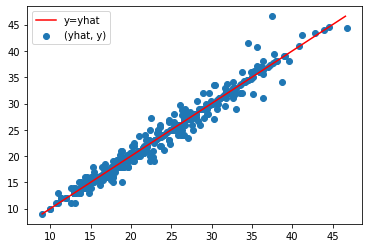

In [92]:
# model = LinearRegression()
# model.fit(phi_with_name(data), data[["mpg"]])
# evaluate_model("cont.+(d/c)+o+n", model, phi_with_name, models)

name, data['Yhat_name'] = train_model_with_phi(data, phi_with_name, data, Y)
evaluate_and_plot_mpg("name", data, y="mpg", yhat="Yhat_name")

## 8.4 Quick Reflection

Notice that as we added more features we were able to improve the accuracy of our model.  This is not always a good thing and we will see the problems associated with this in a future lecture.  

It is also worth noting that our feature functions each depended on the last and the in some cases we were converting sparse features to dense features.  There is a better way to deal with feature pipelines using the scikit-learn pipelines module.  

## Success!!!!!

# Appendix A

In [53]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

def plot_y_vs_yhat(df, y, yhat):
    plt.figure()
    Y, Yhat = df[y], df[yhat]
    plt.scatter(Yhat, Y, label='(yhat, y)')
    cmin, cmax = max(Yhat.min(), Y.min()), min(Yhat.max(), Y.max())
    plt.plot([cmin, cmax], [cmin, cmax], color='red', label='y=yhat')
    plt.legend()

def plot_predictions(df, x, y, yhat):
    plt.figure()
    X, Y, Yhat = df[x], df[y], df[yhat]
    plt.plot(X, Y, label='ground truth')
    plt.plot(X, Yhat, label='prediction')
    plt.legend()

def plot_predictions_over_time(df, x, y, yhat):
    time = df.groupby(by='time').agg('mean').reset_index()
    plot_predictions(time, x, y, yhat)

def evaluate(df, y, yhat):
    """Compute and print error metrics"""
    Y, Yhat = df[y], df[yhat]
    metrics = {
        'MSE': mean_squared_error(Y, Yhat),
        'MAE': mean_absolute_error(Y, Yhat),
        'RMSE': np.sqrt(mean_squared_error(Y, Yhat)),
    }
    print("Mean Squared Error:", metrics['MSE'])
    print("Mean Absolute Error:", metrics['MAE'])
    print("Root Mean Squared Error:", metrics['RMSE'])
    return metrics